# Исследование поведения пользователей мобильного приложения

В стартапе по доставке еды, требуется провести анализ мобильного приложения. Целей у данного исследования две:
1. Анализ воронки продаж
2. Сравнение результатов A/A/B-теста после изменения шрифтов

# Содержание

1. [Этап 1 - Загрузка, проверка и подготовка данных](#stage_1)

  * [Загрузка данных](#stage_1_load)
  * [Подготовка и проверка данных](#stage_1_chek_setup)
  * [Вывод первого этапа](#stage_1_summary)
        

2. [Этап 2 - Анализ данных](#stage_2)
   
  * [Количественные данные](#stage_2_counts)
  * [Количество данных за периоды](#stage_2_period)
  * [Вывод второго этапа](#stage_2_summary)


3. [Этап 3 - Воронка продаж](#stage_3)

  * [Вывод третьего этапа](#stage_3_summary)
  

4. [Этап 4 - Анализ результатов A/A/B-теста](#stage_4)
  
  * [Формирование данных для тестов ](#stage_4_groups)
  * [Статистические тесты ](#stage_4_test)
    * [Тесты между контрольными группами](#stage_4_test_control) 
    * [Тесты между контрольной и экспериментальной группами](#stage_4_test_unite) 
    * [Тесты между первой контрольной и экспериментальной группами](#stage_4_test_0_exp) 
    * [Тесты между второй контрольной и экспериментальной группами](#stage_4_test_1_exp) 
  * [Вывод четвертого этапа](#stage_4_summary)
  
  
5. [Общий вывод](#conclusion)

Импорт библиотек необходимых для проведения анализа

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.stats.proportion import proportions_ztest

# Этап 1 - Загрузка, проверка и подготовка данных<a id="stage_1"></a>

## Загрузка данных<a id="stage_1_load"></a>

Загрузим лог использования приложения в датафрейм и выведем его на экран

In [2]:
df = pd.read_csv('datasets/logs_exp.csv', sep='\t')
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Отобразим общую информацию об его содержимом

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Лог содержит следующую информацию:
* EventName — название события
* DeviceIDHash — уникальный идентификатор пользователя
* EventTimestamp — время события
* ExpId — номер эксперимента

Всего в таблице 244126 записей, пропущеных значений нет, преобразование типов не требуется

## Подготовка и проверка данных<a id="stage_1_chek_setup"></a>

Выведем наименования столбцов датафрейма на экран

In [4]:
df.columns

Index(['EventName', 'DeviceIDHash', 'EventTimestamp', 'ExpId'], dtype='object')

Для удобства работы сократим наименования и переведем их в нижний регистр

In [5]:
df.columns = ['event', 'deviceid', 'timestamp', 'group']

Проверим таблицу на дубликаты

In [6]:
df.duplicated().sum()

413

In [7]:
df.duplicated().sum() / len(df) * 100

0.16917493425526162

413 полностью повторяющихся строк (0,16%), удалим их из таблицы

In [8]:
df = df.drop_duplicates().reset_index(drop=True)

Выведем на экран уникальные записи столбца содержащего названия событий

In [9]:
df['event'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

Повторов нет, названия выглядят нормально

На основании столбца с временем события в UNIX создадим столбцы с датой и временем в привычном формате:

Столбец с датой и временем события

In [10]:
df['date_time'] = pd.to_datetime(df['timestamp'], unit='s')

Выделим из нового столбца только дату

In [11]:
df['date'] = df['date_time'].dt.date

Выведем на экран уникальные значения из столбца с идентификатором эксперимента

In [12]:
df['group'].unique()

array([246, 248, 247], dtype=int64)

Идентификаторы 246 и 247 обозначают контрольные группы, 248 - группа с измененными шрифтами, для наглядности переименуем их:
* 246 -> A-0
* 247 -> A-1
* 248 -> B

In [13]:
df['group'] = df['group'].replace({246:'A-0',247:'A-1',248:'B'})

## Вывод первого этапа<a id="stage_1_summary"></a>

Мы загрузили предоставленный лог в датафрейм, в нем не было пропущеных данных, изменений типов также не потребовалось

В логе были найдены и удалены дубликаты (413 строк), далее мы переименовали столбцы (для удобства)

На основании времени в UNIX формате мы создали два новых столбца: 1) с датой и временем, 2) с датой, а после этого изменили идентификаторы экспериментов на более привычнее

# Этап 2 - Анализ данных<a id="stage_2"></a>

## Количественные данные<a id="stage_2_counts"></a>

In [14]:
len(df)

243713

В нашем распоряжении имеются записи о 243713 событиях

In [15]:
df['deviceid'].nunique()

7551

Эти события совершены 7551 уникальными пользователями

Создадим сводную таблицу с количеством событий совершенных каждым пользователем выведем информацию о распределении на экран

In [16]:
df.pivot_table(index='deviceid', values='event', aggfunc='count')['event'].describe().round(2)

count    7551.00
mean       32.28
std        65.15
min         1.00
25%         9.00
50%        20.00
75%        37.00
max      2307.00
Name: event, dtype: float64

В среднем, на каждого пользователя приходится по 32 события за все время наблюдения, медианное количество (20) ниже, что свидетельствует о большом количестве выбросов - максимальное количество событий пришедшихся на одного пользователя 2307

Построим диаграмму размаха этого распределения

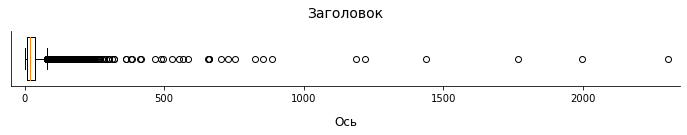

In [17]:
plt.figure(figsize=(12,1))
plt.boxplot(df.pivot_table(index='deviceid', values='event', aggfunc='count')['event'], 
            vert=False, widths=0.8)
plt.title('Заголовок', fontsize=14, pad=14)
plt.xlabel('Ось', fontsize=12, labelpad=12)
plt.ylabel(None)
plt.xticks(fontsize=10)
plt.yticks([])
plt.xlim(-50,2350)
sns.despine()
plt.show()

На диаграмме наблюдается огромный хвост выбросов, судя по открытым источникам с анализом подобной информации, это нормальная ситуация для пользователей мобильных приложений - всегда есть некоторое количество человек которые пользуются приложением аномально большое количество раз

## Количество данных за периоды<a id="stage_2_period"></a>

Выведем минимум и максимум столбца сдатой для того чтобы определить период когда проводились эксперименты

In [18]:
print('Начало периода:', df['date_time'].min())
print('Конец периода', df['date_time'].max())

Начало периода: 2019-07-25 04:43:36
Конец периода 2019-08-07 21:15:17


В логе есть данные за две недели (с 25.07.2019 по 07.08.2019), построим гистограмму чтоб оценить распределение

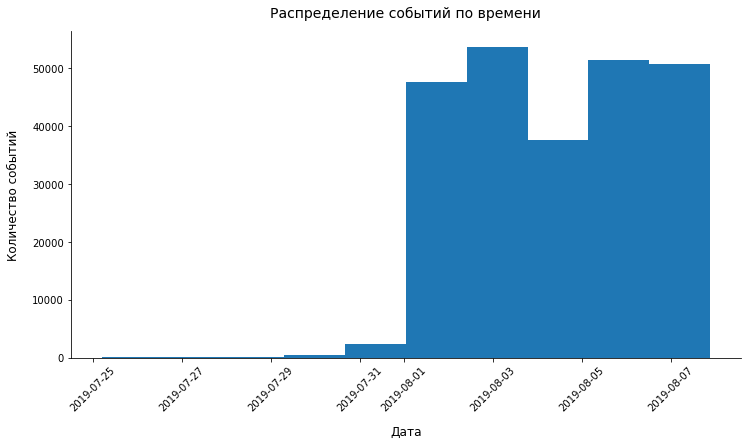

In [19]:
plt.figure(figsize=(12,6))
plt.hist(df['date_time'])
plt.title('Распределение событий по времени', fontsize=14, pad=14)
plt.xlabel('Дата', fontsize=12, labelpad=12)
plt.ylabel('Количество событий', fontsize=12, labelpad=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
sns.despine()
plt.show()

Левая половина диаграммы практически не содержит записей о количестве событий, построим гистограмму по дням

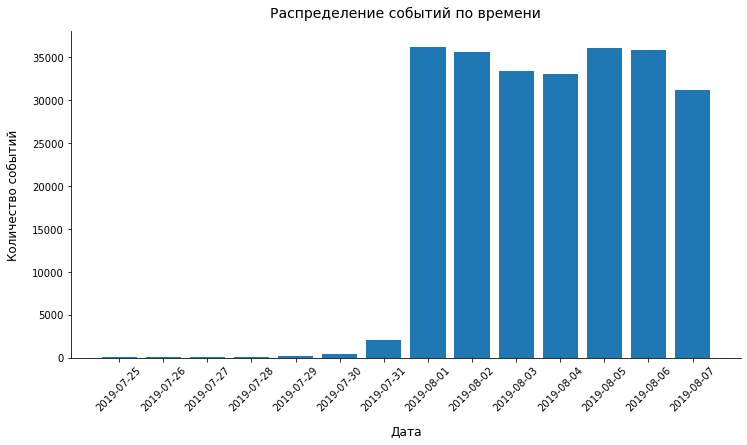

In [20]:
plt.figure(figsize=(12,6))
plt.bar(x=df.pivot_table(index='date', values='event', aggfunc='count').index,
        height=df.pivot_table(index='date', values='event', aggfunc='count')['event'])
plt.title('Распределение событий по времени', fontsize=14, pad=14)
plt.xlabel('Дата', fontsize=12, labelpad=12)
plt.ylabel('Количество событий', fontsize=12, labelpad=12)
plt.xticks(ticks=df.pivot_table(index='date', values='event', aggfunc='count').index,
           rotation=45, fontsize=10)
plt.yticks(fontsize=10)
sns.despine()
plt.show()

На гистограмме распределения в разрезе дней мы видим что данные за первую неделю эксперимента у нас не полные

Количество записей за первую неделю

In [21]:
len(df[df['date'] <= pd.Timestamp('2019-07-31')])

2826

За вторую

In [22]:
len(df[df['date'] > pd.Timestamp('2019-07-31')])

240887

Всего 2826 записей о первой неделе, против 240887 записей о второй

Поделим лог на две недели

In [23]:
first_week = df[df['date'] <= pd.Timestamp('2019-07-31')]
second_week = df[df['date'] > pd.Timestamp('2019-07-31')]

И найдем количество уникальных пользователей в каждом

In [24]:
display(first_week['deviceid'].nunique())
display(second_week['deviceid'].nunique())

1451

7534

Проверим сколько не повторяющихся пользователей из первой недели мы потеряем если отбросим эти данные

In [25]:
len(first_week[~first_week['deviceid'].isin(second_week['deviceid'])]['deviceid'].drop_duplicates())

17

Всего 17 пользователей

Отобразим количество пользователей по группам A/A/B-теста за все время

In [26]:
df.pivot_table(index='group', values='deviceid', aggfunc=pd.Series.nunique)

,deviceid
group,
A-0,2489
A-1,2520
B,2542


И уникальных для первой недели пользователей которых мы хотим отбросить

In [27]:
first_week[~first_week['deviceid'].isin(second_week['deviceid'])].pivot_table(index='group', 
                                                                              values='deviceid', 
                                                                              aggfunc=pd.Series.nunique)

,deviceid
group,
A-0,5
A-1,7
B,5


Даже по группам их распределение почти равномерное, удалим записи о первой неделе оставив только данные о второй

In [28]:
df = df.drop(first_week.index).reset_index(drop=True)

## Вывод второго этапа<a id="stage_2_summary"></a>

На втором этапе исследования мы провели анализ количественных данных и обнаружили что, всего в нашем распоряжении находятся записи о 243713 собитиях которые совершили 7551 пользователей, при этом в среднм на пользователя приходилось 32 события, однако в этих данных присутствует большое количество выбросов (на одного из пользователей пришлось 2307 событиый за все время), судя по открытым источникам с анализом подобной информации, это нормальная ситуация для пользователей мобильных приложений - всегда есть некоторое количество человек которые пользуются приложением аномально большое количество раз

В логе представлены события за две недели: с 25.07.2019 по 07.08.2019, анализ распределения данных по времени показал что сведения о первой неделе эксперимента в нашем распоряжении не полные, всего 2826 записей о первой неделе, против 240887 записей о второй.

По количеству пользователей также наблюдается перекос: 1451 уникальный пользователей на первой неделе и 7534 на второй, при этом всего 17 человек воспользовались приложением на первой неделе и не пользовались на второй.

После анализа групп эксперимента, по которым были распределены эти пользователи (A-0:5, A-1:7, B:5), нами было принято решение об удалении из таблицы неполных данных за первую неделю

# Этап 3 - Воронка продаж<a id="stage_3"></a>

Подсчитаем количество разных событий в логе

In [29]:
df.pivot_table(index='event', values='deviceid', aggfunc='count').sort_values('deviceid', ascending=False)

,deviceid
event,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


В нашем распоряжении находятся записи о следующих событиях:
* MainScreenAppear - появление главного экрана приложения (пользователь открыл приложение)
* OffersScreenAppear - появление окна товара (пользователь открыл карточку товара)
* CartScreenAppear - появление окна корзины (пользователь открыл корзину)
* PaymentScreenSuccessful - появление окна об успешной оплате (пользователь оплатил покупку)
* Tutorial - обучение (пользователь открыл раздел с обучением)

Построим таблицу с количеством уникальных пользователей совершавших то или иное событие:

In [30]:
users_per_event = df.pivot_table(index='event', values='deviceid', aggfunc=pd.Series.nunique).sort_values('deviceid', ascending=False)
users_per_event

,deviceid
event,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


Добавим долю пользователей (в процентах) от общего количества уникальных пользователей

In [31]:
users_per_event['%'] = (users_per_event['deviceid'] / df['deviceid'].nunique() * 100).round(2)
users_per_event

,deviceid,%
event,,
MainScreenAppear,7419,98.47
OffersScreenAppear,4593,60.96
CartScreenAppear,3734,49.56
PaymentScreenSuccessful,3539,46.97
Tutorial,840,11.15


События, отсортированные по количеству уникальных пользователей, сами выстроились в воронку:

1. Пользователь открывает приложение
2. Открывает карточку товара
3. Открывает корзину
4. Совершает покупку

Событие в логе, которое не входит в воронку продаж - прохождение пользователем обучения

Определим функцию которая будет строить воронку по переданному в аргументе датафрейму

In [32]:
def funnel(data):
    funnel = data[data['event'] != 'Tutorial'].pivot_table(index='event', values='deviceid', aggfunc=pd.Series.nunique).sort_values('deviceid', ascending=False).reset_index()
    for index in funnel.index:
        if index == 0:
            funnel.loc[index, '%'] = 100
        else:
            funnel.loc[index, '%'] = round(funnel.loc[index, 'deviceid'] / funnel.loc[index-1, 'deviceid'] * 100, 2)
    return funnel

Применим ее ко всему датафрейму

In [33]:
funnel_df = funnel(df)
funnel_df

,event,deviceid,%
0,MainScreenAppear,7419,100.00
1,OffersScreenAppear,4593,61.91
2,CartScreenAppear,3734,81.30
3,PaymentScreenSuccessful,3539,94.78


Открыло приложение 7439 пользователей, карточку товара открыло 62% от того числа (4613 пользователей), из них 81% перешел в корзину, и 94,61% пользователей с предыдущего этапа совершили оплату

Больше всего пользователей теряется на втором шаге - 38% пользователей открывают приложение, но не открывают карточки товаров, возможно они просматривают каталог товаров и ни один из них не может их заинтересовать

Отобразим воронку событий на диаграмме, для этого определим специальную функцию которая будет строить воронку продаж средствами библиотеки mathplotlib

In [34]:
def funnel_plot(funnel_data):
    starts = []
    for index in funnel_data.index:
        start = (funnel_data.loc[0, 'deviceid'] - funnel_data.loc[index, 'deviceid']) / 2
        starts.append(start)
    starts = starts[::-1]

    plt.figure(figsize=(11,6))
    plt.barh(y=funnel_data.sort_values('deviceid', ascending=True)['event'],
             width=funnel_data.sort_values('deviceid', ascending=True)['deviceid'],
             left=starts)
    plt.title('Воронка событий', fontsize=14, pad=14)
    plt.xlabel('Пользователи перешедшие с предыдущего этапа', fontsize=12, labelpad=12)
    plt.ylabel(None)
    plt.xticks([])
    plt.xlim(0,funnel_data.loc[0, 'deviceid'])
    plt.yticks(fontsize=10)
    for index, value in enumerate(funnel_data.sort_values('deviceid', ascending=True)['%']):
        plt.text(funnel_data.loc[0, 'deviceid']/2, index, str(value)+'%', 
                 fontsize=12, color='white', horizontalalignment='center', weight='bold')
    sns.despine(top=True, right=True, left=False, bottom=True)
    plt.show()

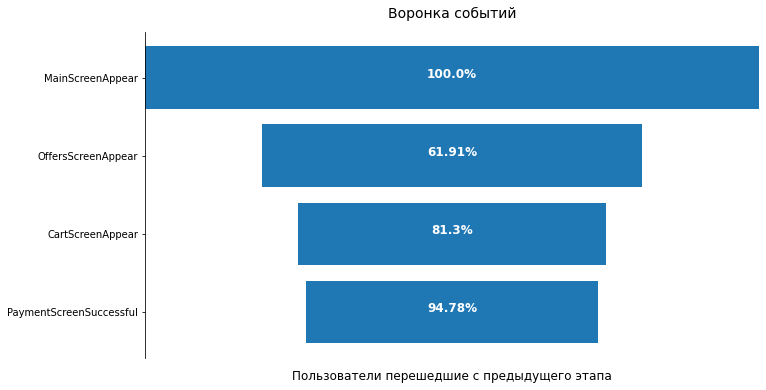

In [35]:
funnel_plot(funnel_df)

Рассчитаем долю пользователей прошедший полный путь по воронке (от открытия приложения до оплаты)

In [36]:
round(funnel_df[funnel_df['event'] == 'PaymentScreenSuccessful']['deviceid'].values[0] / funnel_df[funnel_df['event'] == 'MainScreenAppear']['deviceid'].values[0], 2)

0.48

## Вывод третьего этапа<a id="stage_3_summary"></a>

В логе содержатся записи о следующих событиях:
* MainScreenAppear - появление главного экрана приложения (пользователь открыл приложение)
* OffersScreenAppear - появление окна товара (пользователь открыл карточку товара)
* CartScreenAppear - появление окна корзины (пользователь открыл корзину)
* PaymentScreenSuccessful - пявление окна об успешной оплате (пользователь оплатил покупку)
* Tutorial - обучение (пользователь открыл раздел с обучением)

После сортировки таблицы событий по количеству уникальных пользователей мы смогли составить следующую воронку продаж:

1. Пользователь открывает приложение
2. Открывает карточку товара
3. Открывает корзину
4. Совершает покупку

В воронку продаж не вошло только собитие Tutorial - прохождение пользователем обучения

После этого мы построили воронку событий и увидели что за неделю эксперимента открыло приложение 7439 пользователей, в карточку товара перешли 62% от того числа (4613 пользователей), из них 81% открыли корзину товаров, и практически все из тех пользователей кто открывал корзину (94,61%) совершили оплату

Больше всего пользователей теряется на втором шаге - 38% пользователей открывают приложение, но не открывают карточки товаров, возможно они просматривают каталог товаров и ни один из них не может их заинтересовать

В итоге 48% пользователей открывших приложение совершили оплату

# Этап 4 - Анализ результатов A/A/B-теста<a id="stage_4"></a>

## Формирование данных для тестов <a id="stage_4_groups"></a>

Прежде чем делить данные на группы убедимся что каждый пользователь попал только в одну группу теста

In [37]:
groups_per_device = df.pivot_table(index='deviceid', values='group', aggfunc=pd.Series.nunique)
groups_per_device[groups_per_device['group'] > 1]

,group
deviceid,


Пользователей у которых больше одной записи о группе нет, отобразим количество пользователей в каждой из групп теста

In [38]:
df.pivot_table(index='group', values='deviceid', aggfunc=pd.Series.nunique)

,deviceid
group,
A-0,2484
A-1,2513
B,2537


Распределение по группам практически равномерное

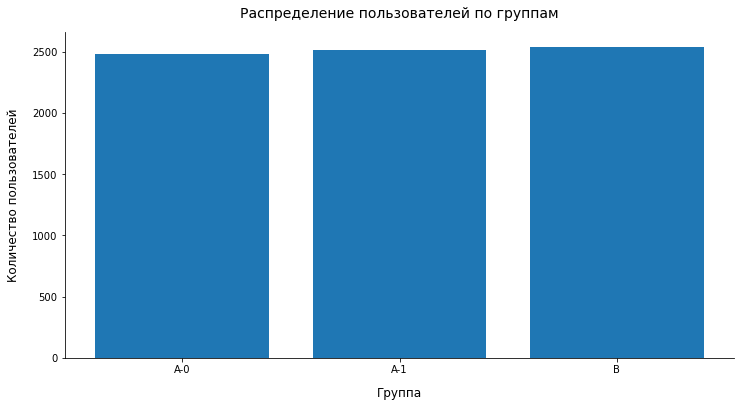

In [39]:
plt.figure(figsize=(12,6))
plt.bar(x=df.pivot_table(index='group', values='deviceid', aggfunc=pd.Series.nunique).index,
        height=df.pivot_table(index='group', values='deviceid', aggfunc=pd.Series.nunique)['deviceid'])
plt.title('Распределение пользователей по группам', fontsize=14, pad=14)
plt.xlabel('Группа', fontsize=12, labelpad=12)
plt.ylabel('Количество пользователей', fontsize=12, labelpad=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.despine()
plt.show()

Поделим лог на группы

In [40]:
A_0 = df[df['group'] == 'A-0']
A_1 = df[df['group'] == 'A-1']
B = df[df['group'] == 'B']

Для каждой группы теста построим воронки продаж

Группа A-0

In [41]:
funnel_A_0 = funnel(A_0)
funnel_A_0

,event,deviceid,%
0,MainScreenAppear,2450,100.00
1,OffersScreenAppear,1542,62.94
2,CartScreenAppear,1266,82.10
3,PaymentScreenSuccessful,1200,94.79


Группа A-1

In [42]:
funnel_A_1 = funnel(A_1)
funnel_A_1

,event,deviceid,%
0,MainScreenAppear,2476,100.00
1,OffersScreenAppear,1520,61.39
2,CartScreenAppear,1238,81.45
3,PaymentScreenSuccessful,1158,93.54


Группа B

In [43]:
funnel_B = funnel(B)
funnel_B

,event,deviceid,%
0,MainScreenAppear,2493,100.00
1,OffersScreenAppear,1531,61.41
2,CartScreenAppear,1230,80.34
3,PaymentScreenSuccessful,1181,96.02


## Статистические тесты <a id="stage_4_test"></a>

Для тестирования равенства пропорций мы будем использовать Z-тест пропорций

* Нулевая гипотеза - между пропорциями нет статистически значимой разницы

* Альтернативная гипотеза - разница между попорциями статистически значима

Критерий значимости определим в 5%

In [44]:
alpha = 0.05

Определим специальную функцию для проведения теста, ее аргументами будут две воронки событий и наименования этапов на которые переходят пользователи

In [45]:
def z_test(data1, data2, trials, successes):
    trials1 = data1.loc[data1[data1['event'] == trials].index[0], 'deviceid']
    trials2 = data2.loc[data2[data2['event'] == trials].index[0], 'deviceid']
    successes1 = data1.loc[data1[data1['event'] == successes].index[0], 'deviceid']
    successes2 = data2.loc[data2[data2['event'] == successes].index[0], 'deviceid']
    
    test_data = pd.DataFrame({trials:[trials1,trials2], successes:[successes1,successes2]})
    test_data['%'] = round(test_data[successes] / test_data[trials] * 100, 2)
    display(test_data)
    
    p_value = proportions_ztest(test_data[successes], test_data[trials])[1]

    print('p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

### Тесты между контрольными группами<a id="stage_4_test_control"></a> 

Сначала протестируем контрольные группы

#### Запуск приложения - Открытие карточки товара

In [46]:
z_test(funnel_A_0, funnel_A_1, 'MainScreenAppear', 'OffersScreenAppear')

,MainScreenAppear,OffersScreenAppear,%
0,2450,1542,62.94
1,2476,1520,61.39


p-значение:  0.2622344959255778
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Открытие карточки товара - Открытие корзины

In [47]:
z_test(funnel_A_0,funnel_A_1,'OffersScreenAppear','CartScreenAppear')

,OffersScreenAppear,CartScreenAppear,%
0,1542,1266,82.10
1,1520,1238,81.45


p-значение:  0.6393754713145264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Открытие корзины - Оплата покупки

In [48]:
z_test(funnel_A_0,funnel_A_1,'CartScreenAppear','PaymentScreenSuccessful')

,CartScreenAppear,PaymentScreenSuccessful,%
0,1266,1200,94.79
1,1238,1158,93.54


p-значение:  0.18243439408067652
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Результаты тестов показывают что наблюдаемая разница в пропорциях пользователей переходящих с этапа на этап в контрольных группах статистически не значима и разделение на группы работает корректно, значит мы можем объединить группы A-0 и A-1 и сравнивать с группой B уже объединенную группу

### Тесты между контрольной и экспериментальной группами<a id="stage_4_test_unite"></a> 

Объединим группы A-0 и A-1 в одну

In [49]:
A = df[df['group'].isin(['A-0','A-1'])]

Построим воронку событий для объединенной группы

In [50]:
funnel_A = funnel(A)
funnel_A

,event,deviceid,%
0,MainScreenAppear,4926,100.00
1,OffersScreenAppear,3062,62.16
2,CartScreenAppear,2504,81.78
3,PaymentScreenSuccessful,2358,94.17


Проведем статистические тесты для событий воронки

#### Запуск приложения - Открытие карточки товара

In [51]:
z_test(funnel_A,funnel_B,'MainScreenAppear','OffersScreenAppear')

,MainScreenAppear,OffersScreenAppear,%
0,4926,3062,62.16
1,2493,1531,61.41


p-значение:  0.5308589432077624
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Открытие карточки товара - Открытие корзины

In [52]:
z_test(funnel_A,funnel_B,'OffersScreenAppear','CartScreenAppear')

,OffersScreenAppear,CartScreenAppear,%
0,3062,2504,81.78
1,1531,1230,80.34


p-значение:  0.23905954279947372
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Открытие корзины - Оплата покупки

In [53]:
z_test(funnel_A,funnel_B,'CartScreenAppear','PaymentScreenSuccessful')

,CartScreenAppear,PaymentScreenSuccessful,%
0,2504,2358,94.17
1,1230,1181,96.02


p-значение:  0.01711443431954697
Отвергаем нулевую гипотезу: между долями есть значимая разница


Между первыми двумя пропорциями (Запуск приложения - Открытие карточки товара и Открытие карточки товара - Открытие корзины) разница статистически не значима

Но для последних пропорций воронки (количество пользователей открывших корзину и количество пользователей совершивших оплату) контрольной и экспериментальной групп тест показал что разница статистически значима

Тестирование с объединенной контрольной группой показало значимость разницы только в последней пропорции, проверим контрольные группы по раздельности

### Тесты между первой контрольной и экспериментальной группами<a id="stage_4_test_0_exp"></a> 

#### Запуск приложения - Открытие карточки товара

In [54]:
z_test(funnel_A_0,funnel_B,'MainScreenAppear','OffersScreenAppear')

,MainScreenAppear,OffersScreenAppear,%
0,2450,1542,62.94
1,2493,1531,61.41


p-значение:  0.2684281587249231
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Открытие карточки товара - Открытие корзины

In [55]:
z_test(funnel_A_0,funnel_B,'OffersScreenAppear','CartScreenAppear')

,OffersScreenAppear,CartScreenAppear,%
0,1542,1266,82.10
1,1531,1230,80.34


p-значение:  0.2112170818054685
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Открытие корзины - Оплата покупки

In [56]:
z_test(funnel_A_0,funnel_B,'CartScreenAppear','PaymentScreenSuccessful')

,CartScreenAppear,PaymentScreenSuccessful,%
0,1266,1200,94.79
1,1230,1181,96.02


p-значение:  0.1429534127041901
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Разница в пропорциях между первой контрольной группой и экспериментальной статистически не значима

### Тесты между второй контрольной и экспериментальной группами<a id="stage_4_test_1_exp"></a> 

#### Запуск приложения - Открытие карточки товара

In [57]:
z_test(funnel_A_1,funnel_B,'MainScreenAppear','OffersScreenAppear')

,MainScreenAppear,OffersScreenAppear,%
0,2476,1520,61.39
1,2493,1531,61.41


p-значение:  0.9869365252844515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Открытие карточки товара - Открытие корзины

In [58]:
z_test(funnel_A_1,funnel_B,'OffersScreenAppear','CartScreenAppear')

,OffersScreenAppear,CartScreenAppear,%
0,1520,1238,81.45
1,1531,1230,80.34


p-значение:  0.4364903513062256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Открытие корзины - Оплата покупки

In [59]:
z_test(funnel_A_1,funnel_B,'CartScreenAppear','PaymentScreenSuccessful')

,CartScreenAppear,PaymentScreenSuccessful,%
0,1238,1158,93.54
1,1230,1181,96.02


p-значение:  0.005677465395736324
Отвергаем нулевую гипотезу: между долями есть значимая разница


Между второй контрольной и экспериментальной группами статистически значимая разница наблюдается только в последней пропорции

## Вывод четвертого этапа<a id="stage_4_summary"></a>

После того как мы убедились в том что каждый пользователь попал только в одну группу теста мы поделили лог на три группы: A-0, A-1 и B и построили для каждой воронку продаж

Для оценки статистической значимости пропорций мы использовали Z-тест и получили следующие результаты:

1. Между контрольными группами (A-0 и A-1) статистически значимой разницы не наблюдается
2. Между объединенной контрольной группой и экспериментальной статистически значимая разница наблюдается только в последней пропорции (количество пользователей открывших корзину и количество пользователей совершивших оплату)
3. Разница между первой контрольной группой и экспериментальной группами статистически не значима
4. Между второй и экспериментальной группами статистически значима разница в последней пропорции

Всего мы провели 12 статистических тестов, при выбранном уровне значимости (5%) результат каждого двадцатого теста может быть неверным. Если бы мы использовали уровень значимости 10% то каждый десятый был бы ошибочным, то есть один из проведенных 12 тестов мог бы быть неверным, в том числе это мог быть один из двух тестов показавших статистически значимую разницу между пропорциями.

Конкретно в нашем случае ни одно из p-value тестов показавших статистическую незначимость расхождения пропорций не было меньше 10% и ни одно из p-value тестов показавших статистическую значимость разницы между пропорциями не было больше 5%

# Общий вывод<a id="conclusion"></a>

После загрузки предоставленного лога в датафрейм, в нем не было обнаружено пропущеных данных, изменений типов также не потребовалось, были найдены и удалены дубликаты (413 строк) и переименованы столбцы (для удобства), дололнительно было создано два новых столбца: 1) с датой и временем, 2) с датой. Последним шагом на этапе предобработки данных мы заменили идентификаторы экспериментов на более привычные

На втором этапе исследования мы провели анализ количественных данных и обнаружили, что в нашем распоряжении имеются записи о 243713 собитиях которые совершили 7551 пользователей, при этом в среднм на пользователя приходилось 32 события

В логе представлены события за две недели: с 25.07.2019 по 07.08.2019, анализ распределения данных по времени показал что сведения о первой неделе эксперимента в нашем распоряжении не полные, всего 2826 записей о первой неделе, против 240887 записей о второй, после анализа групп эксперимента, по которым были распределены данные пользователей за первую неделю, нами было принято решение об удалении из таблицы данных за первую неделю

На третьем этапе анализа мы построили воронку событий и выявили, что воронка состоит из следующих действий:
1. Пользователь открывает приложение
2. Открывает карточку товара
3. Открывает корзину
4. Совершает покупку

Анализ воронки показал, что за неделю эксперимента открыло приложение 7439 пользователей, в карточку товара перешли 62% человек от того числа (4613), из них 81% открыли корзину товаров, и практически все из тех пользователей кто открывал корзину (94,61%) совершили оплату

Больше всего пользователей теряется на втором шаге - 38% пользователей открывают приложение, но не открывают карточки товаров, возможно они просматривают каталог товаров и ни один из них не может их заинтересовать

В итоге 48% пользователей открывших приложение проходят воронку событий до конца и совершают оплату покупок

Четвертый этап анализа состоял из анализа проведенного A/A/B-теста, после проведенных тестов мы получили следующие результаты:

* Между контрольными группами (A-0 и A-1) статистически значимой разницы не наблюдается
* Между объединенной контрольной группой и экспериментальной статистически значимая разница наблюдается только в последней пропорции (количество пользователей открывших корзину и количество пользователей совершивших оплату)
* Разница между первой контрольной группой и экспериментальной группами статистически не значима
* Между второй и экспериментальной группами статистически значима разница в последней пропорции

Всего мы провели 12 статистических тестов, при выбранном уровне значимости (5%) результат каждого двадцатого теста может быть неверным. Если бы мы использовали уровень значимости 10% то каждый десятый был бы ошибочным, то есть один из проведенных 12 тестов мог бы быть неверным, в том числе это мог быть один из двух тестов показавших статистически значимую разницу между пропорциями.

Конкретно в нашем случае ни одно из p-value тестов показавших статистическую незначимость расхождения пропорций не было меньше 10% и ни одно из p-value тестов показавших статистическую значимость разницы между пропорциями не было больше 5%, таким образом повышение уровня значимости с 5% до 10% не изменит резултаты теста, но увеличит вероятность того что тесты были ошибочны